In [1]:
import os
import datetime
import pickle
import pandas as pd
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import string
import re
import numpy as np
import nltk
from tqdm import tqdm

2024-01-25 10:26:59.592578: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-25 10:26:59.635443: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-25 10:26:59.635542: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-25 10:26:59.637732: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-25 10:26:59.646217: I tensorflow/core/platform/cpu_feature_guar

In [2]:
print(f"Tensor Flow Version: {tf.__version__}")
print()
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "AVAILABLE" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.15.0

GPU is AVAILABLE


2024-01-25 10:27:01.636045: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-25 10:27:01.733756: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-25 10:27:01.734333: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
max_tokens = 100_000
sequence_length = 30

# Preparing the data

In [4]:
file_path = '../data/en-pl.csv'
df = pd.read_csv(file_path)
df['source'] = df['pl']
df['target'] = df['en'].apply(lambda x: '[start] ' + x + ' [end]')
df = df.drop(['pl', 'en'], axis=1)

df.sample(5)

,source,target
5069376,Maksymalna dotacja nie może przekroczyć 100 00...,[start] The maximum grant may not exceed EUR 1...
4298877,"• Wkład NATO, Audyt, Audyt","[start] • NATO Contributions, Audit of, an Aud..."
4963584,"SFC argumentuje, że Agencja nie powinna skupia...",[start] The SFC argues that the Agency should ...
1734784,"W rzeczywistości ekonomiści stwierdzili, że po...","[start] In fact, economists have found that up..."
5704854,Komitet zwraca się do kolejnego sprawozdania o...,[start] The Committee asks the next report to ...


In [5]:
df = df.truncate(after=1_300_000)

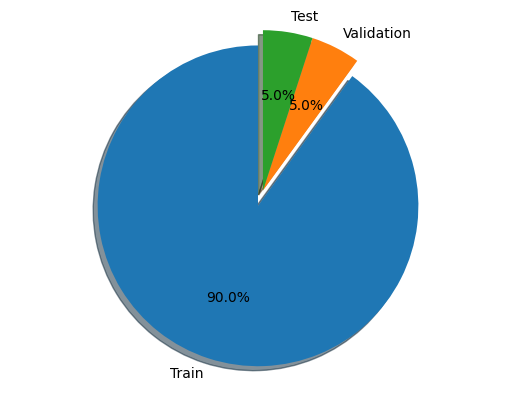

In [5]:
# shuffle the data
df = df.sample(frac=1, random_state=0).reset_index(drop=True)

# split the data
train_size = int(len(df) * 0.9)
val_size = int(len(df) * 0.05)
test_size = int(len(df) * 0.05)

train_df = df[:train_size]
val_df = df[train_size:train_size+val_size]
test_df = df[train_size+val_size:]

# display the data sets
labels = 'Train', 'Validation', 'Test'
sizes = [len(train_df), len(val_df), len(test_df)]
explode = (0.1, 0, 0)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.show()


In [6]:
# define a custom standardization function that convert to lowercase and strips all punctuations except "[" and "]" (so we can tell apart "start" from "[start]").
strip_chars = string.punctuation
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")
 
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

In [8]:
# tokenize the data using our custom standardization function
source_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=sequence_length,
)
target_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=sequence_length + 1, # add +1 token to our target sentences since they'll be shifted right by 1 during training
    standardize=custom_standardization,
)

# index all tokens in the source and target sentences
train_source_texts = train_df['source'].values
train_target_texts = train_df['target'].values

2024-01-24 22:18:15.048218: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-24 22:18:15.048473: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-24 22:18:15.048545: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [9]:
source_vectorization.adapt(train_source_texts)

In [13]:
target_vectorization.adapt(train_target_texts)

In [11]:
def save_text_vectorization(text_vec, path):
    standardize = text_vec._standardize
    text_vec._standardize = None
    pickle.dump({
        'config': text_vec.get_config(),
        'weights': text_vec.get_weights()
        }, open(path, "wb")
    )
    text_vec._standardize = standardize

In [7]:
def load_text_vectorization(path, standardize=None):
    from_disk = pickle.load(open(path, "rb"))
    new_v = tf.keras.layers.TextVectorization.from_config(from_disk['config'])
    if standardize:
        new_v._standardize = standardize
    new_v.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))
    new_v.set_weights(from_disk['weights'])
    return new_v

In [12]:
save_text_vectorization(source_vectorization, '../checkpoints/source_vec.pkl')

In [14]:
save_text_vectorization(target_vectorization, '../checkpoints/target_vec.pkl')

In [8]:
source_vectorization = load_text_vectorization('../checkpoints/source_vec.pkl')

2024-01-25 10:28:08.338495: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-25 10:28:08.339089: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-25 10:28:08.339167: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [9]:
target_vectorization = load_text_vectorization('../checkpoints/target_vec.pkl', custom_standardization)

In [10]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = tf.keras.layers.Embedding(input_dim=input_dim, output_dim=output_dim) # token embedding layer
        self.position_embeddings = tf.keras.layers.Embedding(input_dim=sequence_length, output_dim=output_dim) # position embedding layer
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.dropout = tf.keras.layers.Dropout(dropout)

    def call(self, inputs, training):
        embedded_tokens = self.token_embeddings(inputs) # embed the tokens
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1) # create the positional information
        embedded_positions = self.position_embeddings(positions) # embed the positions 
        added = embedded_tokens + embedded_positions # add the token and position embeddings to create the positional embeddings
        return self.dropout(added, training=training)

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "input_dim": self.input_dim,
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
        })
        return config

In [11]:
def shape_list(x):
    static = x.shape.as_list()
    dynamic = tf.shape(x)
    return [dynamic[i] if s is None else s for i, s in enumerate(static)]

def attention_mask(nd, ns, *, dtype):
    i = tf.range(nd)[:,None]
    j = tf.range(ns)
    m = i >= j - ns + nd
    return tf.cast(m, dtype)

def mask_attn_weights(w):
    _, _, nd, ns = shape_list(w)
    b = attention_mask(nd, ns, dtype=w.dtype)
    b = tf.reshape(b, [1, 1, nd, ns])
    w = w*b - tf.cast(1e10, w.dtype)*(1-b)
    return w

In [12]:
def scaled_dot_product_attention(q, k, v, use_causal_mask=False):
    d_k = tf.cast(tf.shape(k)[-1], tf.float32)
    scores = tf.matmul(q, k, transpose_b=True) # Matmul of Q and K
    scaled_scores = scores / tf.math.sqrt(d_k) # Scale
    if use_causal_mask:
        scaled_scores = mask_attn_weights(scaled_scores) # Mask (opt.)
    weights = tf.nn.softmax(scaled_scores, axis=-1) # SoftMax
    output = tf.matmul(weights, v) # Matmul of SoftMax and V
    return output

In [13]:
class MultiAttention(tf.keras.layers.Layer):
    def __init__(self, embed_dim, h, dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.h = h
        if embed_dim % h != 0:
            raise ValueError(
                f"dimension of the embedding space = {embed_dim} should be divisible by number of heads = {h}"
            )
        self.q_linear = tf.keras.layers.Dense(embed_dim)
        self.k_linear = tf.keras.layers.Dense(embed_dim)
        self.v_linear = tf.keras.layers.Dense(embed_dim)
        self.concat_linear = tf.keras.layers.Dense(embed_dim)
        self.dropout = tf.keras.layers.Dropout(dropout)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, shape=(batch_size, -1, self.h, self.embed_dim // self.h))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def concat_heads(self, x, batch_size):
        x = tf.transpose(x, perm=[0, 2, 1, 3])
        return tf.reshape(x, (batch_size, -1, self.embed_dim))

    def call(self, q, k, v, training, use_causal_mask=False):
        batch_size = tf.shape(k)[0]
        q = self.q_linear(q)
        k = self.k_linear(k)
        v = self.v_linear(v)
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        attention = scaled_dot_product_attention(q, k, v, use_causal_mask)
        concat = self.concat_heads(attention, batch_size)
        concat = self.concat_linear(concat)
        concat = self.dropout(concat, training=training)
        return concat

    def get_config(self):
        config = super(MultiAttention, self).get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "h": self.h,
        })
        return config

In [14]:
class TransformerEncoderBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.layer_norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-7)
        self.layer_norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-7)
        self.global_self_attention = MultiAttention(embed_dim=embed_dim, h=num_heads, dropout=dropout)
        self.feed_forward = tf.keras.Sequential(
            [tf.keras.layers.Dense(dense_dim, activation="relu"),
             tf.keras.layers.Dense(embed_dim),]
        )
        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, training):
        # Post layer normalization + residual connections
        x = self.layer_norm_1(x + self.global_self_attention(q=x, k=x, v=x))
        x = self.layer_norm_2(x + self.dropout(self.feed_forward(x), training=training))
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
        })
        return config

In [15]:
class TransformerDecoderBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.causal_self_attention = MultiAttention(embed_dim=embed_dim, h=num_heads)
        self.cross_attention = MultiAttention(embed_dim=embed_dim, h=num_heads)
        self.feed_forward = tf.keras.Sequential(
            [tf.keras.layers.Dense(dense_dim, activation="relu"),
             tf.keras.layers.Dense(embed_dim),]
        )
        self.layer_norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-7)
        self.layer_norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-7)
        self.layer_norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-7)
        self.dropout = tf.keras.layers.Dropout(dropout)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
        })
        return config

    def call(self, x, context, training):
        # Post layer normalization + residual connections
        x = self.layer_norm_1(x + self.causal_self_attention(q=x, k=x, v=x, use_causal_mask=True))
        x = self.layer_norm_2(x + self.cross_attention(q=x, k=context, v=context))
        x = self.layer_norm_3(x + self.dropout(self.feed_forward(x), training=training))
        return x

In [16]:
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, num_layers):
        super(TransformerEncoder, self).__init__()
        self.transformer_encoders = [TransformerEncoderBlock(embed_dim, dense_dim, num_heads) for _ in range(num_layers)]

    def call(self, x):
        for encoder in self.transformer_encoders:
            x = encoder(x)
        return x

In [17]:
class TransformerDecoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, num_layers):
        super(TransformerDecoder, self).__init__()
        self.transformer_decoders = [TransformerDecoderBlock(embed_dim, dense_dim, num_heads) for _ in range(num_layers)]

    def call(self, x, context):
        for encoder in self.transformer_decoders:
            x = encoder(x, context)
        return x

In [18]:
class TransformerModel(tf.keras.Model):
    def __init__(self, sequence_length, max_tokens, embed_dim, dense_dim, num_heads, encoder_layers, decoder_layers):
        super(TransformerModel, self).__init__()

        self.encoder_embedding = PositionalEmbedding(sequence_length, max_tokens, embed_dim)
        self.decoder_embedding = PositionalEmbedding(sequence_length, max_tokens, embed_dim)
        
        self.encoder = TransformerEncoder(embed_dim, dense_dim, num_heads, encoder_layers)
        self.decoder = TransformerDecoder(embed_dim, dense_dim, num_heads, decoder_layers)
        
        # Transformer head
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.dense = tf.keras.layers.Dense(max_tokens, activation="softmax")

    def call(self, inputs, training=False):
        encoder_inputs = inputs['source']
        decoder_inputs = inputs['target']
        
        encoder_embedding = self.encoder_embedding(encoder_inputs)
        decoder_embedding = self.decoder_embedding(decoder_inputs)
        
        encoder_outputs = self.encoder(encoder_embedding)
        decoder_outputs = self.decoder(decoder_embedding, encoder_outputs)

        x = self.dropout(decoder_outputs, training=training)
        x = self.dense(x)
        return x

In [19]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, embedding_dim, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.embedding_dim = tf.cast(embedding_dim, dtype=tf.float32)
        self.warmup_steps = tf.cast(warmup_steps, dtype=tf.float32)

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.embedding_dim) * tf.math.minimum(arg1, arg2)


In [20]:
embed_dim = 64
dense_dim = 128
num_heads = 8
encoder_layers = 3
decoder_layers = 3

In [20]:
learning_rate_scheduler = CustomSchedule(embed_dim)

In [21]:
transformer = TransformerModel(sequence_length, max_tokens, embed_dim, dense_dim, num_heads, encoder_layers, decoder_layers)

In [22]:
def format_dataset(source, target):
    source_vectors = source_vectorization(source)
    target_vectors = target_vectorization(target)
    return ({
        "source": source_vectors, # encoder_inputs
        "target": target_vectors[:, :-1], # decoder_inputs (truncate by 1 to keep it at the same length as decoder_outputs, which is shifted right by 1).
    }, target_vectors[:, 1:]) # decoder_outputs

def make_dataset(df, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((df["source"].values, df["target"].values))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(100_000).prefetch(16).cache()

batch_size = 128
train_ds = make_dataset(train_df, batch_size)
val_ds = make_dataset(val_df, batch_size)

In [23]:
transformer.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

In [24]:
checkpoint_filepath = '../checkpoints/model/'
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='../checkpoints/best/',
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='../checkpoints/last/',
        save_weights_only=True,
        save_best_only=False,
        save_freq=1000
    ),
    # tf.keras.callbacks.LearningRateScheduler(
    #     learning_rate_scheduler
    # ),
]

In [25]:
transformer.fit(train_ds, 
                epochs=10, 
                callbacks=callbacks_list,
                validation_data=val_ds)

Epoch 1/10


2024-01-25 01:10:02.545006: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 31998 of 100000
2024-01-25 01:10:11.888566: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-01-25 01:10:15.346761: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fe3881f6240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-25 01:10:15.346832: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Laptop GPU, Compute Capability 8.6
2024-01-25 01:10:15.363956: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-25 01:10:15.817749: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1706141415.906239    5627 device_compiler.h:186

56003/56003 [==============================] - 11995s 213ms/step - loss: 3.0228 - accuracy: 0.5633 - val_loss: 2.2444 - val_accuracy: 0.6468
Epoch 2/10
56003/56003 [==============================] - 11893s 212ms/step - loss: 2.6110 - accuracy: 0.6075 - val_loss: 2.1575 - val_accuracy: 0.6566
Epoch 3/10
20573/56003 [==========>...................] - ETA: 1:59:59 - loss: 2.5629 - accuracy: 0.6131

In [ ]:
transformer.save('../checkpoints/full_model/')

In [10]:
transformer = tf.keras.models.load_model('../checkpoints/full_model/')

# Testing

In [11]:
target_vocab = target_vectorization.get_vocabulary()
target_index_lookup = dict(zip(range(len(target_vocab)), target_vocab))
max_decoded_sentence_length = 30

def decode_sequence(input_sentence):
    input_sentence = input_sentence.lower()
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = transformer(
            {'source': tokenized_input_sentence, 'target': tokenized_target_sentence})
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = target_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

In [13]:
decode_sequence('idę jutro do kina na film o ptakach')

'[start] i go tomorrow to the cinema on the birds press [end]'

In [16]:
decode_sequence('cześć')

'[start] honour [end]'

In [17]:
decode_sequence('tłumaczenie działa bardzo fajnie')

'[start] the translation is working very important [end]'

In [20]:
decode_sequence('Tylko czasami się myli')

'[start] only sometimes it is [UNK] [end]'

In [24]:
blues = []
for idx, row in tqdm(test_df.iloc[:1000, :].iterrows()):
    source = row['source']
    ref = row['target']
    predicted = decode_sequence(source)
    val = nltk.translate.bleu_score.sentence_bleu([ref], predicted)
    blues.append(val)

sum(blues) / len(blues)

0.4757471513644021

In [35]:
# let's translate 50 random sentences
for i in range(50):
    random_index = np.random.randint(0, len(test_df))
    input_sentence = test_df["source"].iloc[random_index]
    print(input_sentence)
    print(decode_sequence(input_sentence))
    print()

Będziemy głosować przez podniesienie ręki.
[start] we will vote by raising the [UNK] [end]

W odniesieniu do min przeciwpiechotnych Kanada może spojrzeć wstecz na pomyślne zawarcie Konwencji o zakazie wykorzystywania, składowania, produkcji i przekazywania min przeciwpiechotnych oraz o ich zniszczeniu na konferencji w Ottawie w dniach 2-4 grudnia 1997 r.
[start] with respect to antipersonnel mines the [UNK] may look back to the successful conclusion of the [UNK] convention the [UNK] [UNK] and the transmission of antipersonnel mines and to their

a także mając na uwadze, co następuje: w odniesieniu do ust. 2 lit. b), jedna delegacja wyraziła zdecydowane preferencje dla terminu "będzie", większość delegacji, które wyraziły swoje opinie, popierała termin "może".
[start] as well as the [UNK] in respect of article 2 of the commission the delegation expressed a strong preference for the term of the [UNK] that expressed its [UNK] the

W art. 114 ust. 2 dodaje się, co następuje:
[start] in art